# Early Data Analysis
Interpreting data from `batch_analyse.py`. The aim is to filter out the dataset to the required properties to explore potential exocomet-type transits.

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import glob
import data
import os
from astropy.table import Table, unique
from analysis_tools_cython import *
from post_processing_tools import *
from tqdm import tqdm

In [3]:

plt.rcParams['figure.figsize'] = (11.0, 8.0)
plt.rcParams['font.size'] = 16
# plt.rcParams('xtick', labelsize='medium')
# plt.rcParams('ytick', labelsize='medium')

---

### Functions

---

## Creating DataFrame
- data initially used is `corrected flux`, not PCA.

In [4]:
df = get_output('output_s4_corr.txt')
filtered_df = filter_df(df)

In [5]:
df['transit_prob'].unique()

array(['end', 'point', 'artefact', 'maybeTransit'], dtype=object)

`filtered_df` with `maybeTransit` only

In [6]:
filtered_df[filtered_df.transit_prob == 'maybeTransit']

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
451,tesslc_251097365.pkl,-6.227988,-5.239577,1431.037231,1.007030,0.444943,0.004309,0.666657,-0.004357,maybeTransit
3255,tesslc_349304677.pkl,-11.061460,-5.004770,1417.427002,1.027513,0.660868,0.108001,0.562506,-0.001846,maybeTransit
3744,tesslc_294667419.pkl,-8.245355,-6.044350,1417.511597,1.003350,0.252449,0.259025,0.604160,-0.001267,maybeTransit
4110,tesslc_260269815.pkl,-8.504910,-5.610885,1416.907227,1.011990,0.218342,0.017988,0.604177,-0.002083,maybeTransit
4932,tesslc_425061268.pkl,-5.540712,-5.083577,1426.719238,1.009823,0.336213,0.023657,0.520829,-0.003736,maybeTransit
...,...,...,...,...,...,...,...,...,...,...
959927,tesslc_260353466.pkl,-5.377422,-5.068079,1428.344971,1.005412,0.068871,0.204643,0.645845,-0.000831,maybeTransit
961696,tesslc_251062809.pkl,-10.738508,-5.952202,1417.516479,1.046744,0.004003,0.271705,0.749987,-0.002949,maybeTransit
965781,tesslc_36756690.pkl,-6.516477,-5.067790,1417.536987,1.027617,0.027642,0.235591,0.645824,-0.001051,maybeTransit
967214,tesslc_200365213.pkl,-5.652058,-5.120534,1430.179810,1.005069,0.166822,0.148227,0.541675,-0.000957,maybeTransit


---

### Raw Plot

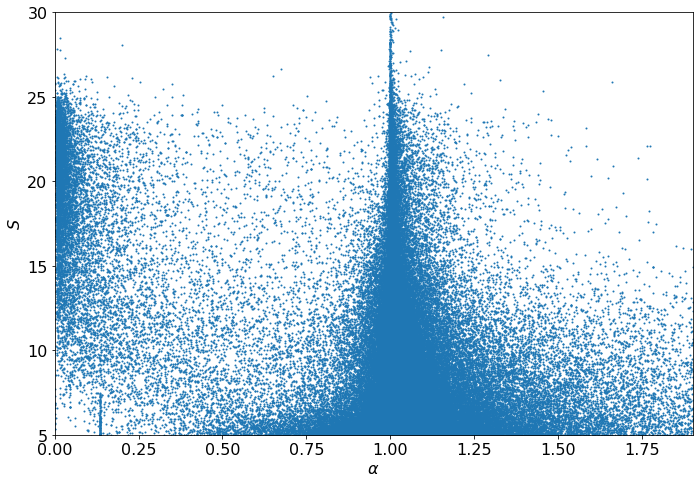

In [7]:
distribution(df.asym_score,abs(df['signal/noise']))

### `MaybeTransit` only

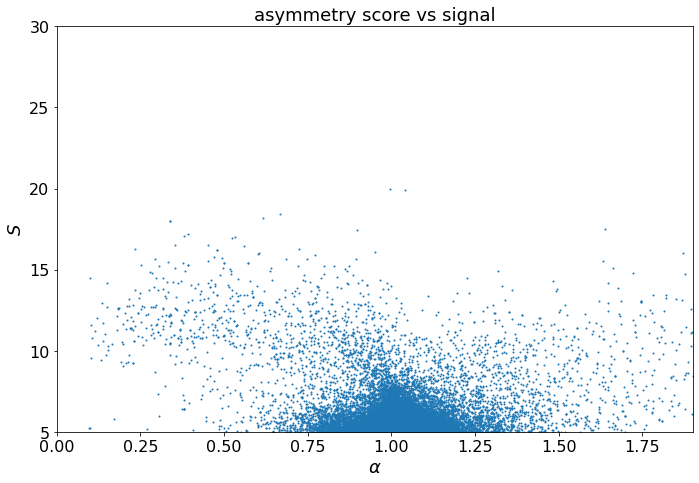

In [8]:
fig,ax = plt.subplots(figsize=(10,7))
ax.scatter(df.asym_score[df.transit_prob == 'maybeTransit'],abs(df['signal/noise'][df.transit_prob == 'maybeTransit']),s=1)
ax.set_xlim(0,1.9)
ax.set_ylim(5,30)
ax.set_xlabel('$\\alpha$',fontsize=18)
ax.set_ylabel('$S$',fontsize=18)
ax.set_title('asymmetry score vs signal',fontsize=18)
fig.tight_layout()
#rect = patches.Rectangle((1.30, 7.40), 0.25, 4, linewidth=3, edgecolor='k', facecolor='none')
#interest_region = patches.Rectangle((1.05,7),3,20, linewidth=1,edgecolor='grey',facecolor='none') # region of interest in Kennedy et al
#ax.add_patch(rect)
#ax.add_patch(interest_region)
plt.show()

Next steps - apply a feature that distinguishes false positives, EB's, etc.

---

### Exploring that black boxed region (S6)

Create our box with the following settings:
- `signal/noise` between 7.4 and 12
- `asym_score` between 1.3 and 1.6

In [8]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.30) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]

In [9]:
to_import = box['file']
#example = box['file'].tail(25)

---

In [10]:
sector = 6
clip = 4
path = '/storage/astro2/phrdhx/tesslcs'
mad_df = data.load_mad()

#### Saving TIC paths

In [11]:
# for i in tqdm(to_import):
#     file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
#     ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
#     store = import_XRPlightcurve(file_paths,sector=sector,drop_bad_points=False)[1]
#     tic = store[0]
#     ra = store[1]
#     dec = store[2]
#     to_export = [tic,ra,dec]
#     with open("weird_tic_path.txt", "a") as output:
#         output.write(file_paths+'\n')

---

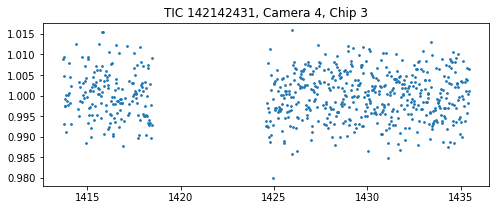

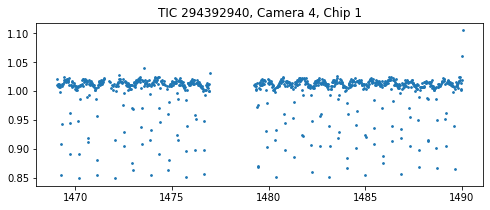

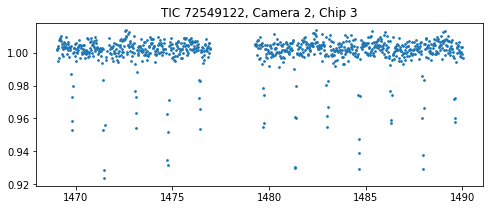

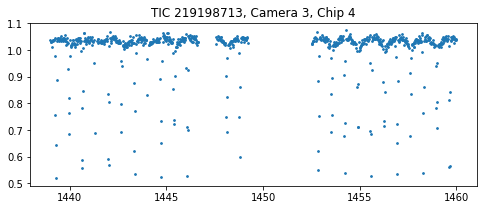

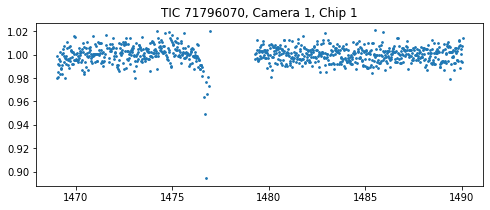

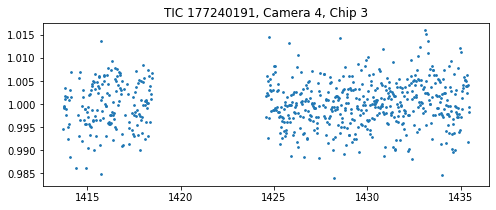

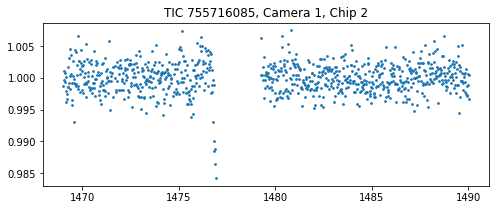

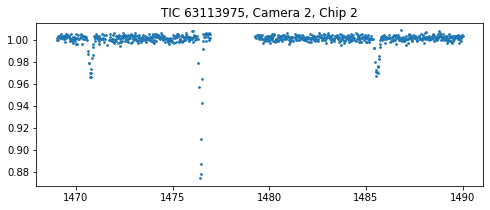

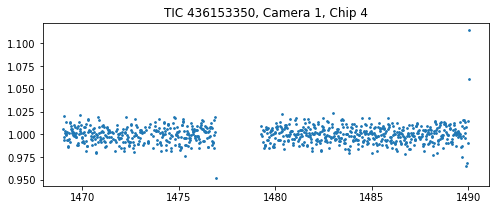

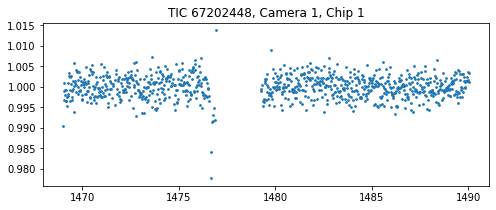

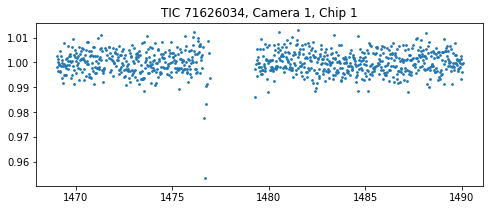

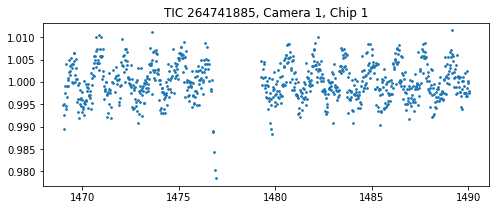

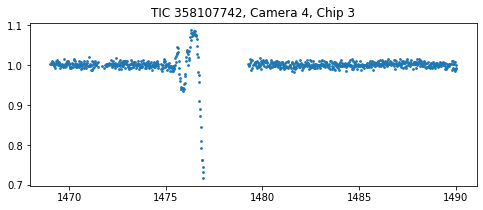

In [12]:
for i in to_import:
    file_paths = glob.glob(os.path.join(path,f'**/**/{i}'))[0]
    ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/**/{i}'))[0])
    table,store = import_XRPlightcurve(file_paths,sector=sector,clip=4,drop_bad_points=True)
    camera = store[4]
    tic = store[0]
    chip = store[5]
    fig,ax = plt.subplots(1,figsize=(8,3))
    ax.set_title(f'TIC {tic}, Camera {camera}, Chip {chip}')
    ax.scatter(table['time'],normalise_lc(table['PCA flux']),s=3)
    plt.show()
    
#     mad_arr = mad_df.loc[:len(table['time'])-1,f"{sector}-{camera}"]
#     sig_clip = sigma_clip(mad_arr,sigma=clip,masked=True)
#     med_sig_clip = np.nanmedian(sig_clip)
#     rms_sig_clip = np.nanstd(sig_clip)
#     mad_cut = mad_arr.values < ~sig_clip.mask 
    

#     fig, ax = plt.subplots(2,2,figsize=(10,8))
#     ax[0,1].scatter(table['time'], mad_arr, s=2)
#     ax[0,1].axhline(np.nanmedian(mad_arr), c='r')
#     ax[0,0].scatter(range(0,len(table['time'])), mad_arr, s=2)
#     ax[0,0].axhline(np.nanmedian(mad_arr), c='r')
#     ax[0,0].axhline(med_sig_clip + clip*rms_sig_clip, c='r')
#     ax[0,0].set_title(f'S{sector}-C{camera}')
#     plt.show()